In [15]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
test_df = pd.read_csv('data/test_64f_somefill0.csv')
train_df = pd.read_csv('data/train_64f_somefill0.csv')
train_df.head()

,SK_ID_CURR,W_DEFAULT,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,AMT_LESS_MAX,DAYS_LATE_AVG,DAYS_LATE_MAX,SK_DPD_DEF,LESS_GRANTED,REJECTED_APPLICATIONS,AMT_CREDIT_SUM_TOTAL,AMT_CREDIT_SUM_DEBT_TOTAL,AMT_CREDIT_SUM_LIMIT_TOTAL,AMT_CREDIT_SUM_OVERDUE_TOTAL
0,100002,1.0,0,1,0,202500.0,Working,Secondary / secondary special,Single / not married,House / apartment,...,0.000,20.421053,31.0,0.0,0.0,0.0,865055.565,245781.0,31988.565,0.0
1,100003,0.0,0,0,0,270000.0,State servant,Higher education,Married,House / apartment,...,0.000,7.160000,14.0,0.0,1.0,0.0,1017400.500,0.0,810000.000,0.0
2,100004,0.0,1,1,0,67500.0,Working,Secondary / secondary special,Single / not married,House / apartment,...,0.000,7.666667,11.0,0.0,1.0,0.0,189037.800,0.0,0.000,0.0
3,100006,0.0,0,1,0,135000.0,Working,Secondary / secondary special,Civil marriage,House / apartment,...,0.000,19.375000,77.0,0.0,2.0,1.0,NaN,NaN,NaN,NaN
4,100007,0.0,0,1,0,121500.0,Working,Secondary / secondary special,Single / not married,House / apartment,...,22655.655,4.590909,31.0,0.0,2.0,0.0,146250.000,0.0,0.000,0.0


In [23]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline


categoricals = [
    'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
    'REGION_RATING_CLIENT', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE',
                
]
cols_to_scale = [
    'Avg_Monthly_Balance','Months_Fully_Paid', 
    'Months_Minimum_Paid', 'Months_Minimum_Paid', 
    'AMT_INCOME_TOTAL', 'DAYS_EMPLOYED', 'OWN_CAR_AGE',
    'Age_Years','Employed_Months', 'AMT_LESS_TOTAL',
    'AMT_LESS_MAX', 'DAYS_LATE_MAX', 'SK_DPD_DEF',
    'AMT_CREDIT_SUM_TOTAL', 'AMT_CREDIT_SUM_DEBT_TOTAL',
    'AMT_CREDIT_SUM_LIMIT_TOTAL', 'AMT_CREDIT_SUM_OVERDUE_TOTAL',
    'Tenure_Months', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
]
others = train_df.columns.difference(categoricals + cols_to_scale)

preproc = ColumnTransformer([
    ('cat', OneHotEncoder(), categoricals),
    # ('scaled', MinMaxScaler(), cols_to_scale),
], remainder='passthrough')

In [24]:
X = train_df.drop(columns='W_DEFAULT')
y = train_df['W_DEFAULT']

X = preproc.fit_transform(X)
# X[np.isnan(X)] = 0  #naively fill NA with 0

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [26]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_auc_score, matthews_corrcoef
from sklearn.metrics import precision_recall_curve, auc, make_scorer

def auc_prc(y_true, y_pred):
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    return auc(recall, precision)

auc_prc_score = make_scorer(auc_prc, needs_proba=True)

In [27]:
best_params = {
    'alpha': 5.5691124921440665,
    'colsample_bytree': 0.5,
    'eta': 0.16489585328980133,
    'gamma': 0.74592481207219,
    'lambda': 0.01,
    'max_delta_step': 10.0,
    'max_depth': 4,
    'min_child_weight': 10.0,
    'n_estimators': 250,
    'subsample': 1.0
}

In [28]:
from sklearn.feature_selection import RFECV
from xgboost import XGBClassifier

# xgb = XGBClassifier(
#     alpha=10.0, 
#     colsample_bytree=0.5, 
#     eta=0.06378779149966156, 
#     gamma=0.38372879913599683, 
#     reg_lambda =10.0, 
#     max_depth=9, 
#     min_child_weight=10.0, 
#     n_estimators=250, 
#     subsample=0.9386880085037652
# )
xgb = XGBClassifier(**best_params)
rfecv = RFECV(estimator=xgb, step=1, cv=10, scoring='roc_auc', n_jobs=-1)
rfecv.fit(X_train, y_train)

print(f'Optimal number of features: {rfecv.n_features_}')

Optimal number of features: 47


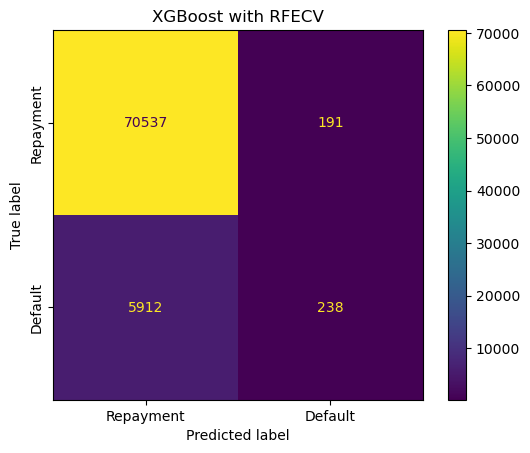

In [29]:
X_train_rfecv = rfecv.transform(X_train)
xgb.fit(X_train_rfecv, y_train)

X_test_rfecv = rfecv.transform(X_test)
y_pred = xgb.predict(X_test_rfecv)
cm = confusion_matrix(y_test, y_pred)

from sklearn.metrics import ConfusionMatrixDisplay
# fig = plt.subplots(figsize=(5,5))
cm_display = ConfusionMatrixDisplay(cm, display_labels=['Repayment', 'Default'])
cm_display.plot()
plt.yticks(rotation=90, va='center')
plt.gca().set_title('XGBoost with RFECV');

In [30]:
results = {}

y_pred = xgb.predict(X_test_rfecv)
y_proba = xgb.predict_proba(X_test_rfecv)

results['XGBoost'] = {
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1': f1_score(y_test, y_pred),
    'ROC AUC': roc_auc_score(y_test, y_proba[:,1]),
    'PRC AUC': auc_prc(y_test, y_pred),
    'MCC': matthews_corrcoef(y_test, y_pred)
}

pd.DataFrame.from_dict(results, orient='index')

,Precision,Recall,F1,ROC AUC,PRC AUC,MCC
XGBoost,0.554779,0.038699,0.072351,0.776383,0.335189,0.131101


In [31]:
scoring = {
    'auc_prc': auc_prc_score, 
    'precision': make_scorer(precision_score), 
    'recall': make_scorer(recall_score),
    'mcc': make_scorer(matthews_corrcoef),
    'auc_roc': make_scorer(roc_auc_score, needs_proba=True)
}

from sklearn.model_selection import cross_validate

X_rfecv = rfecv.transform(X)
scores = cross_validate(xgb, X_rfecv, y, scoring=scoring)
scores = {key: np.mean(values) for key, values in scores.items()}
results = {}
results['XGBoost Tuned, RFECV'] = {
    'Precision': scores['test_precision'],
    'Recall': scores['test_recall'],
    'AUC PRC': scores['test_auc_prc'],
    'AUC ROC': scores['test_auc_roc'],
    'MCC': scores['test_mcc'],
    'Training Time': scores['fit_time']
}

pd.DataFrame.from_dict(results, orient='index')

,Precision,Recall,AUC PRC,AUC ROC,MCC,Training Time
"XGBoost Tuned, RFECV",0.526773,0.035368,0.262247,0.774918,0.120824,3.853852


In [32]:
X_submit = test_df.drop(columns='W_DEFAULT')
X_submit = preproc.transform(X_submit)
# X_submit[np.isnan(X_submit)] = 0
X_submit = rfecv.transform(X_submit)

y_submit_rfecv = xgb.predict_proba(X_submit)

pd.Series(y_submit_rfecv[:,1], index=test_df.SK_ID_CURR, name='TARGET').to_csv('submits/tuned_xgb_rfecv_64f.csv')

#### SHAP

In [47]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([('preproc', preproc), ('rfecv', rfecv)])
X_direct = pipe.transform(train_df.drop(columns='W_DEFAULT'))
rfecv_features = pipe.get_feature_names_out()
rfecv_features = ['_'.join(name.split('_')[2:]) for name in rfecv_features]

In [46]:
import shap

# Create SHAP explainer
explainer = shap.Explainer(xgb, X_train_rfecv)
shap_values = explainer(X_train_rfecv)

100%|===================| 230494/230633 [16:08<00:00]        

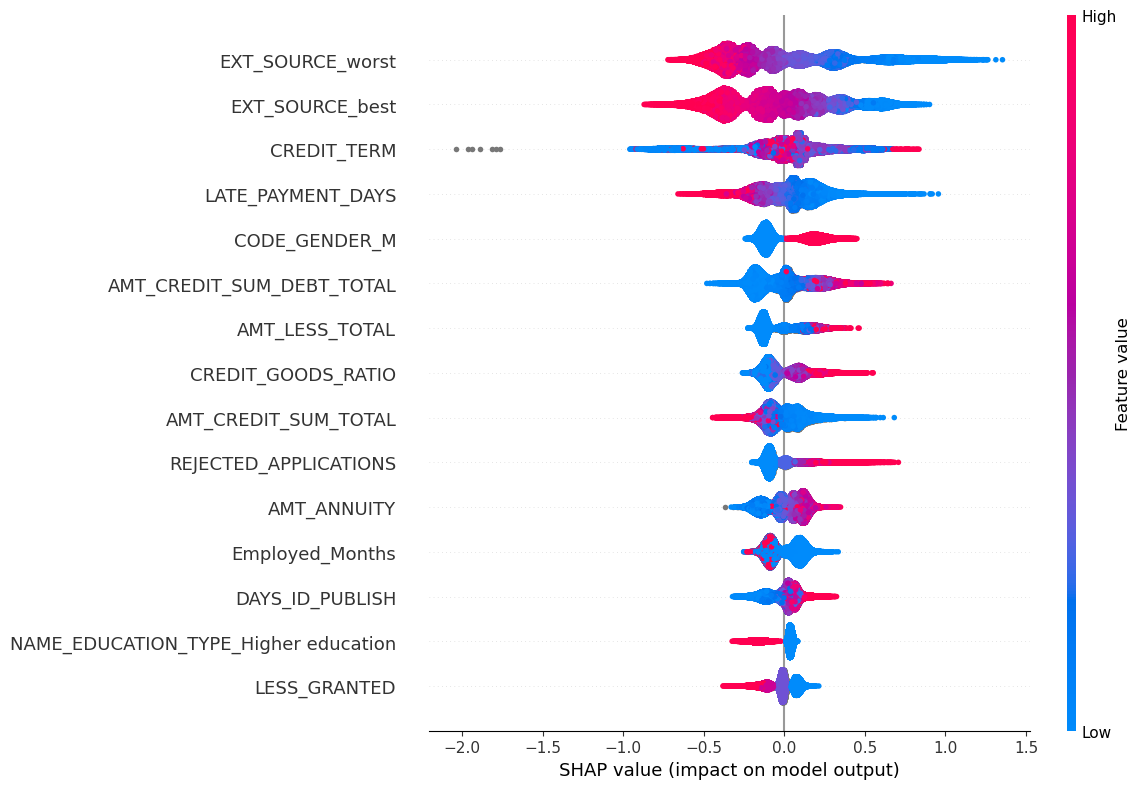

In [52]:
# fig, ax = plt.subplots(figsize=(12,8))
shap.summary_plot(shap_values, X_train_rfecv, feature_names=rfecv_features, max_display=15, plot_size=(12,8))
plt.show()

#### ADASYN and Other Sampling

In [ ]:
from imblearn.over_sampling import ADASYN
adasyn = ADASYN(sampling_strategy=0.3, random_state=1)
X_adasyn, y_adasyn = adasyn.fit_resample(X_train, y_train)

In [10]:
from sklearn.feature_selection import RFECV
from xgboost import XGBClassifier

xgb = XGBClassifier()
rfecv_adasyn = RFECV(estimator=xgb, step=1, cv=10, scoring=make_scorer(matthews_corrcoef), n_jobs=4)
rfecv_adasyn.fit(X_adasyn, y_adasyn)

print(f'Optimal number of features: {rfecv_adasyn.n_features_}')

Optimal number of features: 65


In [11]:
X_adasyn_rfecv = rfecv_adasyn.transform(X_adasyn)
xgb.fit(X_adasyn_rfecv, y_adasyn)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

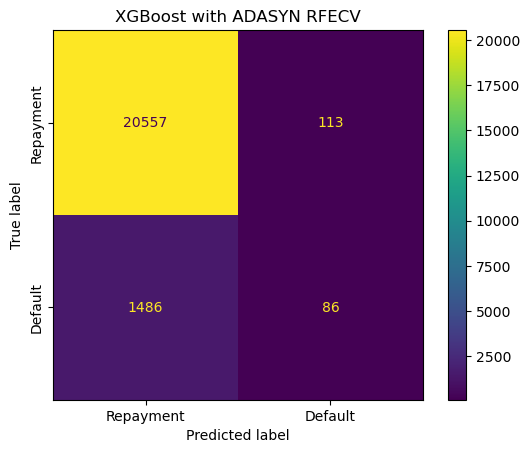

In [29]:
X_test_rfecv = rfecv_adasyn.transform(X_test)
y_pred = xgb.predict(X_test_rfecv)
cm = confusion_matrix(y_test, y_pred)

from sklearn.metrics import ConfusionMatrixDisplay
# fig = plt.subplots(figsize=(5,5))
cm_display = ConfusionMatrixDisplay(cm, display_labels=['Repayment', 'Default'])
cm_display.plot()
plt.yticks(rotation=90, va='center')
plt.gca().set_title('XGBoost with ADASYN RFECV');

In [27]:
results = {}

y_pred = xgb.predict(X_test_rfecv)
y_proba = xgb.predict_proba(X_test_rfecv)

results['XGBoost + ADASYN'] = {
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1': f1_score(y_test, y_pred),
    'ROC AUC': roc_auc_score(y_test, y_proba[:,1]),
    'PRC AUC': auc_prc(y_test, y_pred),
    'MCC': matthews_corrcoef(y_test, y_pred)
}

pd.DataFrame.from_dict(results, orient='index')

,Precision,Recall,F1,ROC AUC,PRC AUC,MCC
XGBoost + ADASYN,0.432161,0.054707,0.09712,0.742814,0.276839,0.134016


In [36]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek

seed = None
ros = RandomOverSampler(random_state=seed)
rus = RandomUnderSampler(random_state=seed)
smote = SMOTE(random_state=seed)
adasyn = ADASYN(random_state=seed)
tomek = TomekLinks()
smotetomek = SMOTETomek(random_state=seed)

methods = {
    # 'Original': 'passthrough',
    'Random Oversampling': ros,
    'Random Undersampling': rus,
    'SMOTE': smote,
    'ADASYN': adasyn,
    'Tomek': tomek,
    'SMOTETomek': smotetomek,
}

In [33]:
scoring = {
    'auc_prc': auc_prc_score, 
    'precision': make_scorer(precision_score), 
    'recall': make_scorer(recall_score),
    'mcc': make_scorer(matthews_corrcoef),
    'auc_roc': make_scorer(roc_auc_score)
}

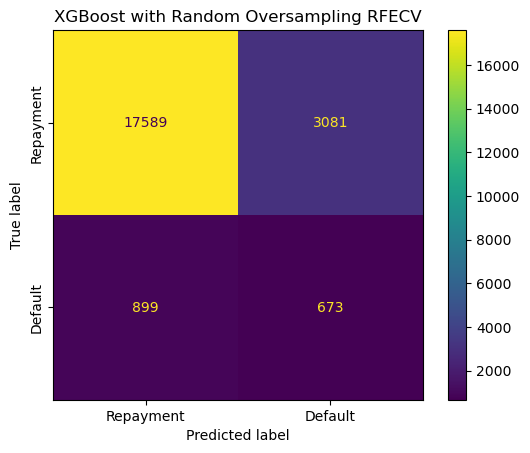

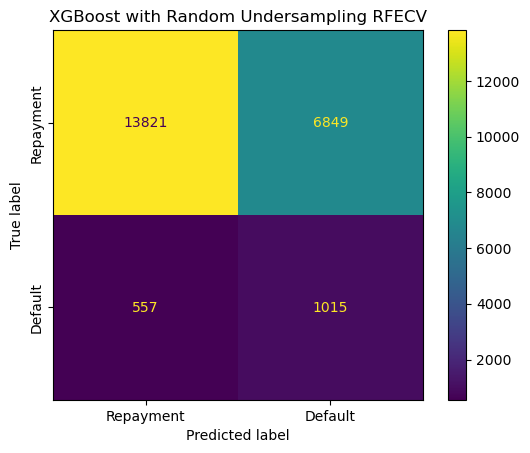

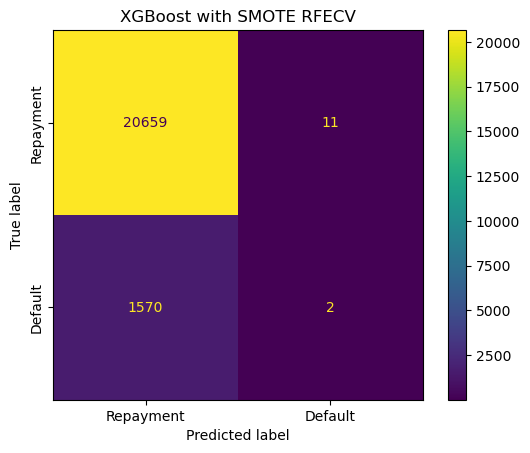

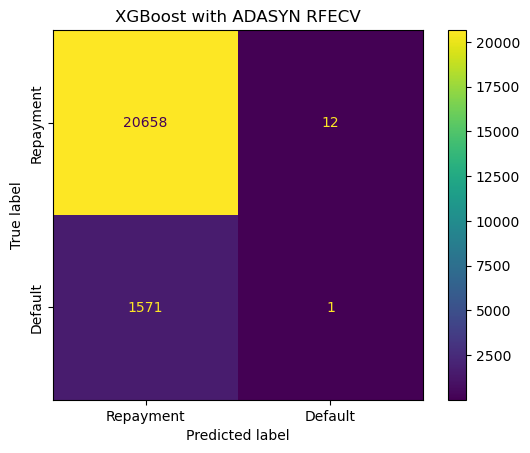

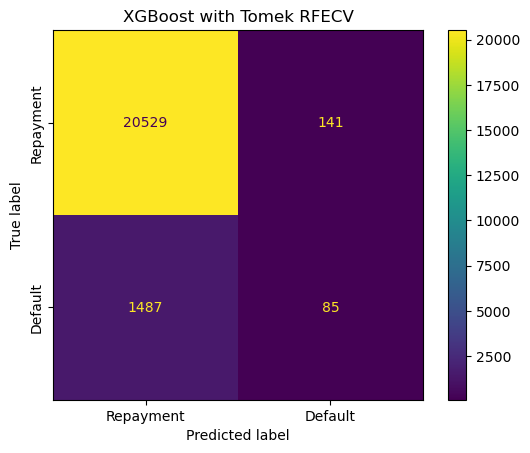

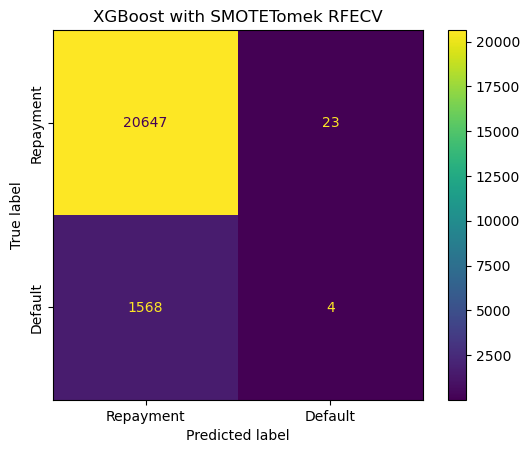

Results for XGBoost


,Precision,Recall,F1,ROC AUC,PRC AUC,MCC
Random Oversampling,0.179275,0.428117,0.252722,0.719112,0.323906,0.190943
Random Undersampling,0.129069,0.645674,0.215134,0.723877,0.399893,0.168502
SMOTE,0.153846,0.001272,0.002524,0.648771,0.112853,0.007848
ADASYN,0.076923,0.000636,0.001262,0.649563,0.074096,0.000589
Tomek,0.376106,0.054071,0.094549,0.739990,0.248516,0.120746
SMOTETomek,0.148148,0.002545,0.005003,0.646792,0.110595,0.010538


In [40]:
from sklearn.model_selection import cross_validate
from imblearn.pipeline import Pipeline

all_results = []
models = {'XGBoost': XGBClassifier()}

rfecv_dict = {}

for model_name, model in models.items():
    results_model = {}

    for method, resampler in methods.items():

        X_samp, y_samp = resampler.fit_resample(X_train, y_train)
        rfecv = RFECV(estimator=model, step=1, cv=10, scoring=make_scorer(matthews_corrcoef), n_jobs=4)
        rfecv_dict[method] = rfecv

        rfecv.fit(X_samp, y_samp)

        X_samp_reduced = rfecv.transform(X_samp)
        model.fit(X_samp_reduced, y_samp)

        X_test_reduced = rfecv.transform(X_test)
        y_pred = model.predict(X_test_reduced)
        y_proba = model.predict_proba(X_test_reduced)
        cm = confusion_matrix(y_test, y_pred)

        from sklearn.metrics import ConfusionMatrixDisplay
        cm_display = ConfusionMatrixDisplay(cm, display_labels=['Repayment', 'Default'])
        cm_display.plot()
        plt.yticks(rotation=90, va='center')
        plt.gca().set_title(f'{model_name} with {method} RFECV')
        plt.show()

        results_model[method] = {
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1': f1_score(y_test, y_pred),
            'ROC AUC': roc_auc_score(y_test, y_proba[:,1]),
            'PRC AUC': auc_prc(y_test, y_pred),
            'MCC': matthews_corrcoef(y_test, y_pred)
        }

        # We porbbaly should figure out how to use RFECV with the pipeline and test this way
        # pipeline = Pipeline(
        #     [
        #         (method, resampler),
        #         [model_name, model]
        #     ]
        # )

        # scores = cross_validate(pipeline, X, y, scoring=scoring)
        # scores = {key: np.mean(values) for key, values in scores.items()}

        # results_model[method] = {
        #     'Precision': scores['test_precision'],
        #     'Recall': scores['test_recall'],
        #     'AUC PRC': scores['test_auc_prc'],
        #     'AUC ROC': scores['test_auc_roc'],
        #     'MCC': scores['test_mcc'],
        #     'Training Time': scores['fit_time']
        # }
    
    results_model = pd.DataFrame.from_dict(results_model, orient='index')
    print(f'Results for {model_name}')
    display(results_model)

    results_model['Model'] = model_name
    all_results.append(results_model.reset_index(names='Sampler'))

all_results = pd.concat(all_results, axis=0).reset_index(drop=True)

In [39]:
results_model

,Model
